In [2]:
import requests
import json
import pandas as pd
import time
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import api_key

In [3]:
def fetch_sensors(nwlat, nwlng, selat, selng):
    """Returns all outdoor PurpleAir sensors within bounded box with geographic data"""
    headers = {"X-API-KEY": api_key.read}
    params = {"fields": "latitude,longitude"}

    url = f"https://api.purpleair.com/v1/sensors?location_type=0&nwlat={nwlat}&nwlng={nwlng}&selat={selat}&selng={selng}"
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        sensor_data = pd.DataFrame(response.json()["data"], columns=["sensor_index", "latitude", "longitude"])
        return sensor_data
    else:
        print(response)

In [4]:
geo_data_1 = fetch_sensors(34.334160, -118.655586, 33.694915, -118.128523)
geo_data_2 = fetch_sensors(34.209516, -118.128523, 33.902632, -117.976620)
geo_data_3 = fetch_sensors(34.165970, -117.976620, 33.982889, -117.802639)
geo_data = pd.concat([geo_data_1, geo_data_2, geo_data_3]).reset_index(drop=True)
geo_data

,sensor_index,latitude,longitude
0,262261,34.042206,-118.510950
1,262257,34.191290,-118.164940
2,262343,34.034600,-118.513794
3,262437,34.076538,-118.488320
4,262449,34.056217,-118.518160
...,...,...,...
652,91477,34.028923,-117.813730
653,110602,33.989310,-117.829440
654,121251,33.993366,-117.959990
655,209869,34.144780,-117.835450


In [5]:
sensors = geo_data["sensor_index"].values.tolist()

In [6]:
def get_sensor_history(id):
    """Returns pm2.5 yearly average from 2023-2024 for given PurpleAir sensor"""
    headers = {"X-API-KEY": api_key.read}
    params = {"fields": "pm2.5_atm"}
    start = 1678838400  # Mar 15, 2023
    end = 1710460800    # Mar 15, 2024
    average = 525600    # Yearly
    
    url = f"https://api.purpleair.com/v1/sensors/{id}/history?start_timestamp={start}&end_timestamp={end}&average={average}"
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        initial_data = response.json()
        sensor_index = initial_data["sensor_index"]
        data_extract = pd.DataFrame(initial_data["data"])  # data has two values, timestamp and pm2.5
        if not data_extract.empty:
            pm = data_extract[1]  # extract pm2.5
            sensor_data = pd.DataFrame({"sensor_index": sensor_index, "pm2.5_atm": pm})
            return sensor_data
    else:
        print(id)
        print(response)

In [7]:
pm_data = pd.DataFrame()
for sensor in sensors:
    sensor_history = get_sensor_history(sensor)
    if pm_data is None or pm_data.empty:
        pm_data = sensor_history
    else:
        pm_data = pd.concat([pm_data, sensor_history]).reset_index(drop=True)
    time.sleep(1)  # avoid rate limit
pm_data

262261
<Response [429]>


,sensor_index,pm2.5_atm
0,1266,11.0180
1,1517,1675.3925
2,1816,13.0085
3,1976,1970.4205
4,2649,10.3895
...,...,...
378,6736,10.8015
379,31399,23.7710
380,69201,13.8975
381,110602,15.0975


In [39]:
pm_sorted = pm_data.sort_values(by="pm2.5_atm", ascending=False)
pm_sorted.head(40)

,sensor_index,pm2.5_atm
3,1976,1970.4205
168,77167,1771.8310
1,1517,1675.3925
272,118579,1442.0465
246,92539,968.5045
290,139716,733.5825
374,188443,683.2290
245,91969,463.7905
278,124961,430.4110
369,162221,378.7520


<Axes: >

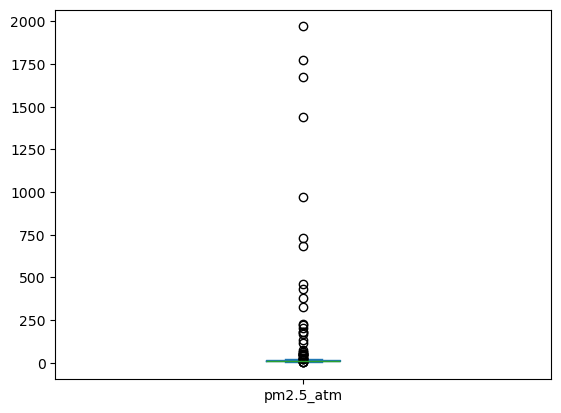

In [37]:
pm_data["pm2.5_atm"].plot(kind="box")

In [51]:
pm_data_no_outliers = pm_data[(pm_data["pm2.5_atm"] >= 5) & (pm_data["pm2.5_atm"] <= 19)]  # drop outliers

<Axes: >

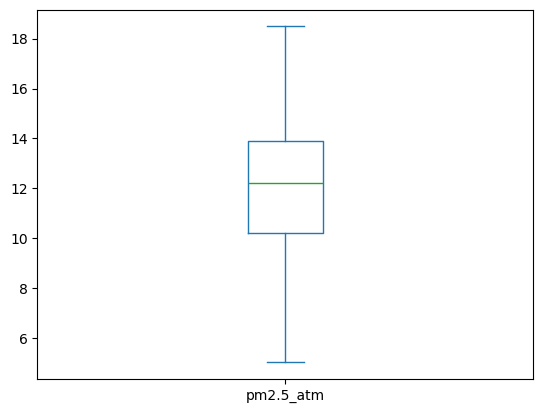

In [53]:
pm_data_no_outliers["pm2.5_atm"].plot(kind="box")

In [55]:
combined_data = geo_data.merge(pm_data_no_outliers, on="sensor_index")
combined_data

,sensor_index,latitude,longitude,pm2.5_atm
0,1266,33.863010,-118.388960,11.0180
1,1816,33.763767,-118.145650,13.0085
2,2649,34.294777,-118.579070,10.3895
3,2946,33.992510,-118.472070,7.7825
4,3586,33.935920,-118.143265,5.0125
...,...,...,...,...
337,1852,34.021534,-117.909910,13.6110
338,6736,34.152060,-117.933990,10.8015
339,69201,34.142437,-117.849440,13.8975
340,110602,33.989310,-117.829440,15.0975


In [57]:
street_map = gpd.read_file("lacounty/County_Boundary.shp")

In [59]:
crs = "EPSG:4326"  # designate coordinate system
geometry = [Point(xy) for xy in zip(combined_data["longitude"], combined_data["latitude"])]
geo_df = gpd.GeoDataFrame(combined_data, crs=crs, geometry=geometry)
geo_df.head()

,sensor_index,latitude,longitude,pm2.5_atm,geometry
0,1266,33.863010,-118.388960,11.0180,POINT (-118.39 33.863)
1,1816,33.763767,-118.145650,13.0085,POINT (-118.15 33.764)
2,2649,34.294777,-118.579070,10.3895,POINT (-118.58 34.295)
3,2946,33.992510,-118.472070,7.7825,POINT (-118.47 33.993)
4,3586,33.935920,-118.143265,5.0125,POINT (-118.14 33.936)


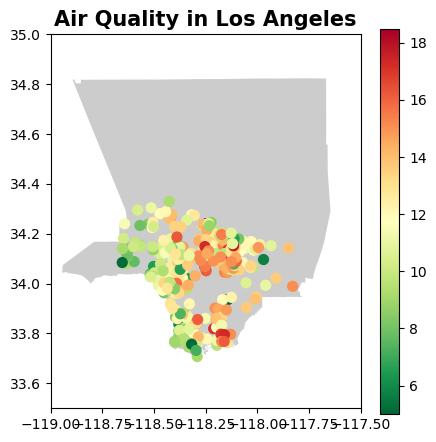

In [61]:
street_map = street_map.to_crs(geo_df.crs)  # match the projection
fig, ax = plt.subplots(figsize=(5,5))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(column="pm2.5_atm", cmap="RdYlGn_r", ax=ax, legend=True, markersize=50)
plt.title("Air Quality in Los Angeles", fontsize=15, fontweight="bold")
plt.xlim(-119, -117.5)
plt.ylim(33.5, 35)
plt.show()